<a href="https://colab.research.google.com/github/Ozedim/Ozedim/blob/main/Project_3_Part_1_(Core)_OGWANG_TREVOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip install pmdarima

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
import zipfile
from matplotlib.ticker import FuncFormatter
# set random seed
SEED = 321
np.random.seed(SEED)

In [15]:
#path for the zipped files
zip_file_path='/content/drive/MyDrive/CodingDojo/04-DataViz/Week13/Data/Chicago_Crime_2001-2022 (1).zip'
with zipfile.ZipFile(zip_file_path,'r') as zip_ref:
  zip_ref.extractall('/content/drive/MyDrive/Crime')

In [16]:
#path to extract file
data='/content/drive/MyDrive/Crime/Data'
#list of files in folder
list = os.listdir(data)
#filter csv files
csv_files = [file for file in list if file.endswith('.csv')]
#empty list to store dataframe
dfs=[]
#looping through csv files
for file in csv_files:
  file_path=os.path.join(data,file)
  df=pd.read_csv(file_path)
  dfs.append(df)
  #Concancate dadaframes
  Crime_df=pd.concat(dfs,ignore_index=True)
  Crime_df

In [17]:
Crime_df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020


Topic 1) Comparing Police Districts
Which district had the most crimes in 2022?
Which had the least?

In [18]:
for file in csv_files:
  file_path=os.path.join(data,file)
  df=pd.read_csv(file_path)
  print(df.head())

        ID                    Date     Primary Type          Description  \
0  1326041  01/01/2001 01:00:00 AM          BATTERY               SIMPLE   
1  1319931  01/01/2001 01:00:00 PM          BATTERY               SIMPLE   
2  1324743  01/01/2001 01:00:00 PM         GAMBLING  ILLEGAL ILL LOTTERY   
3  1310717  01/01/2001 01:00:00 AM  CRIMINAL DAMAGE           TO VEHICLE   
4  1318099  01/01/2001 01:00:00 AM          BATTERY               SIMPLE   

      Location Description  Arrest  Domestic  Beat  District  Ward   Latitude  \
0                RESIDENCE   False     False  1624      16.0   NaN  41.957850   
1                RESIDENCE   False      True   825       8.0   NaN  41.783892   
2                   STREET    True     False   313       3.0   NaN  41.780412   
3                   STREET   False     False  2424      24.0   NaN  42.012391   
4  RESIDENCE PORCH/HALLWAY   False      True   214       2.0   NaN  41.819538   

   Longitude  
0 -87.749185  
1 -87.684841  
2 -87.61197

In [19]:
# Concatenate the DataFrames
Crime_df=pd.concat(dfs,ignore_index=True)

# Print the shape of the DataFrame to check if all the rows have been concatenated.
print(Crime_df.shape)

(7713109, 12)


In [20]:
district_crimes_count=Crime_df['District'].value_counts()
most_crime_district_2022=district_crimes_count.idxmax()
least_crime_district_2022=district_crimes_count.idxmin()
print(f"District with the most crimes in 2022: {most_crime_district_2022}")
print(f"District with the least crimes in 2022: {least_crime_district_2022}")

District with the most crimes in 2022: 8.0
District with the least crimes in 2022: 21.0


Topic 4) Comparing Months

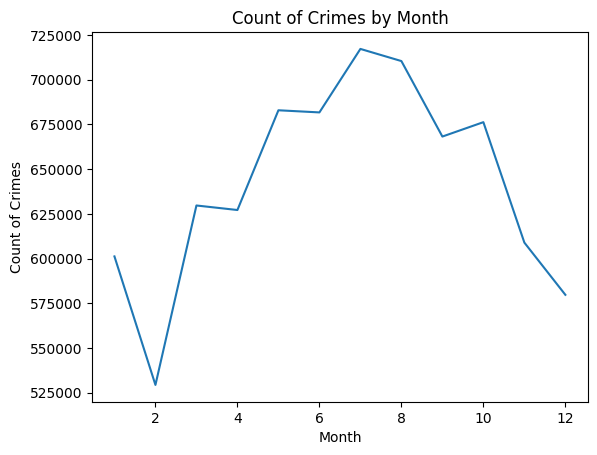

In [21]:
# Add the 'Year' column by extracting it from the 'Date' column
Crime_df['Month'] = pd.to_datetime(Crime_df['Date']).dt.month
# Get the data from combined_df
id_counts_by_month = Crime_df.groupby('Month')['ID'].count()

# Create the line plot
plt.plot(id_counts_by_month.index, id_counts_by_month.values)

# Set the title and axis labels
plt.title('Count of Crimes by Month')
plt.xlabel('Month')
plt.ylabel('Count of Crimes')

# Show the plot
plt.show()

**from the trend above, it shows that most crimes used to happen in the months of July and August**

Topic 3) Comparing AM vs. PM Rush Hour

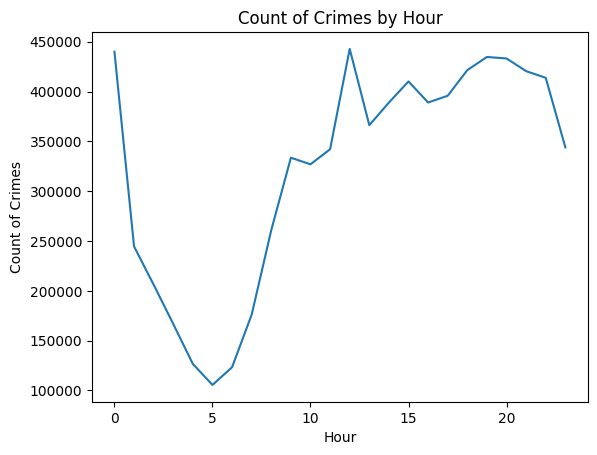

In [22]:
# Add the 'Year' column by extracting it from the 'Date' column
Crime_df['Hour'] = pd.to_datetime(Crime_df['Date']).dt.hour
# Get the data from combined_df3
id_counts_by_hour = Crime_df.groupby('Hour')['ID'].count()

# Create the line plot
plt.plot(id_counts_by_hour.index, id_counts_by_hour.values)

# Set the title and axis labels
plt.title('Count of Crimes by Hour')
plt.xlabel('Hour')
plt.ylabel('Count of Crimes')

# Show the plot
plt.show()

**following the crime hour trend above, its shown that most crimes take place in the afternoon and evening and late night hours**

###Project 3 part 2

In [23]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None,
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)

    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index,
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();

    return fig, ax



In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics


In [25]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d,
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags,
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()

    return fig

In [26]:
def plot_acf_pacf(ts, nlags=20, figsize=(10, 5),
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},
                  annotate_seas=False, m = None,
                 seas_color='black'):

    fig, axes = plt.subplots(nrows=2, figsize=figsize)


    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)

    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)

    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
            ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)

        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()

    return fig



In [27]:
Crime_df.head()

,ID,Date,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Month,Hour
0,1326041,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,1,1
1,1319931,01/01/2001 01:00:00 PM,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,1,13
2,1324743,01/01/2001 01:00:00 PM,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,1,13
3,1310717,01/01/2001 01:00:00 AM,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,1,1
4,1318099,01/01/2001 01:00:00 AM,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,1,1


In [28]:
df =Crime_df.set_index('Date')
df


,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Month,Hour
Date,,,,,,,,,,,,,
01/01/2001 01:00:00 AM,1326041,BATTERY,SIMPLE,RESIDENCE,False,False,1624,16.0,NaN,41.957850,-87.749185,1,1
01/01/2001 01:00:00 PM,1319931,BATTERY,SIMPLE,RESIDENCE,False,True,825,8.0,NaN,41.783892,-87.684841,1,13
01/01/2001 01:00:00 PM,1324743,GAMBLING,ILLEGAL ILL LOTTERY,STREET,True,False,313,3.0,NaN,41.780412,-87.611970,1,13
01/01/2001 01:00:00 AM,1310717,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,2424,24.0,NaN,42.012391,-87.678032,1,1
01/01/2001 01:00:00 AM,1318099,BATTERY,SIMPLE,RESIDENCE PORCH/HALLWAY,False,True,214,2.0,NaN,41.819538,-87.620020,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2022 12:50:00 PM,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966,12,12
12/31/2022 12:50:00 PM,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669,12,12
12/31/2022 12:52:00 AM,12937583,BATTERY,SIMPLE,BARBERSHOP,False,False,1135,11.0,28.0,41.868829,-87.686098,12,0


In [29]:
df.index



Index(['01/01/2001 01:00:00 AM', '01/01/2001 01:00:00 PM',
       '01/01/2001 01:00:00 PM', '01/01/2001 01:00:00 AM',
       '01/01/2001 01:00:00 AM', '01/01/2001 01:00:00 AM',
       '01/01/2001 01:00:00 AM', '01/01/2001 01:00:00 AM',
       '01/01/2001 01:00:00 AM', '01/01/2001 01:00:00 AM',
       ...
       '12/31/2022 12:41:00 PM', '12/31/2022 12:42:00 AM',
       '12/31/2022 12:44:00 AM', '12/31/2022 12:45:00 AM',
       '12/31/2022 12:45:00 PM', '12/31/2022 12:50:00 PM',
       '12/31/2022 12:50:00 PM', '12/31/2022 12:52:00 AM',
       '12/31/2022 12:52:00 PM', '12/31/2022 12:59:00 PM'],
      dtype='object', name='Date', length=7713109)

In [34]:
#checking nulls
Crime_df.isna().sum()

ID                           0
Date                         0
Primary Type                 0
Description                  0
Location Description     10928
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614846
Latitude                 88685
Longitude                88685
Month                        0
Hour                         0
dtype: int64

In [39]:
df = df.dropna(subset=['Location Description','Ward','District','Latitude','Longitude'])
df

,ID,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Month,Hour
Date,,,,,,,,,,,,,
01/01/2001 01:00:00 AM,5462733,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,233,2.0,20.0,41.789084,-87.620849,1,1
01/01/2001 01:00:00 PM,6808288,THEFT,FINANCIAL ID THEFT: OVER $300,APARTMENT,False,False,213,2.0,3.0,41.822551,-87.615632,1,13
01/01/2001 01:00:00 PM,3769790,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,523,5.0,34.0,41.673171,-87.638000,1,13
01/01/2001 01:00:00 AM,3212105,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,True,False,913,9.0,14.0,41.823730,-87.698440,1,1
01/01/2001 01:00:00 AM,3206463,CRIM SEXUAL ASSAULT,PREDATORY,RESIDENCE,False,True,835,8.0,18.0,41.735507,-87.690095,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2022 12:45:00 PM,12937789,CRIMINAL DAMAGE,TO PROPERTY,SMALL RETAIL STORE,False,False,1131,11.0,28.0,41.874153,-87.735239,12,12
12/31/2022 12:50:00 PM,12938029,ASSAULT,SIMPLE,APARTMENT,False,False,1014,10.0,24.0,41.855911,-87.719966,12,12
12/31/2022 12:50:00 PM,12937822,ASSAULT,AGGRAVATED - HANDGUN,APARTMENT,False,True,733,7.0,6.0,41.766546,-87.645669,12,12


In [41]:
# Impute null values
df = df.interpolate()
df.isna().sum()

ID                      0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Latitude                0
Longitude               0
Month                   0
Hour                    0
dtype: int64

In [43]:
df = df.sort_index()
df.index



Index(['01/01/2001 01:00:00 AM', '01/01/2001 01:00:00 AM',
       '01/01/2001 01:00:00 AM', '01/01/2001 01:00:00 PM',
       '01/01/2001 01:00:00 PM', '01/01/2001 01:00:00 PM',
       '01/01/2001 02:00:00 AM', '01/01/2001 02:00:00 PM',
       '01/01/2001 02:00:00 PM', '01/01/2001 03:00:00 AM',
       ...
       '12/31/2022 12:41:00 AM', '12/31/2022 12:41:00 PM',
       '12/31/2022 12:42:00 AM', '12/31/2022 12:44:00 AM',
       '12/31/2022 12:45:00 AM', '12/31/2022 12:45:00 PM',
       '12/31/2022 12:50:00 PM', '12/31/2022 12:50:00 PM',
       '12/31/2022 12:52:00 AM', '12/31/2022 12:52:00 PM'],
      dtype='object', name='Date', length=7012248)

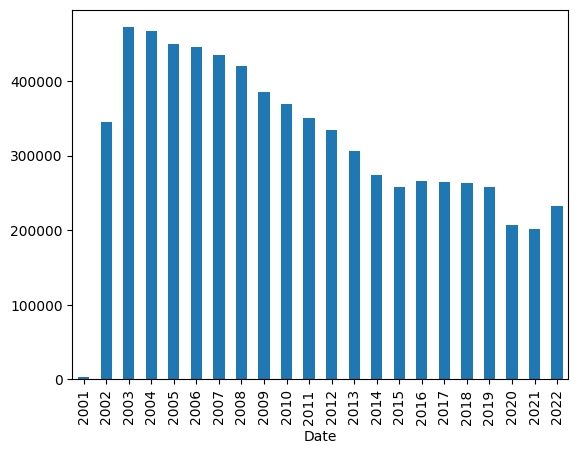

In [45]:
# Convert the index to a DatetimeIndex
df.index = pd.to_datetime(df.index)

# Access the year attribute
years = df.index.year

# Plot the bar chart
years.value_counts().sort_index().plot(kind='bar');

<Axes: ylabel='Primary Type'>

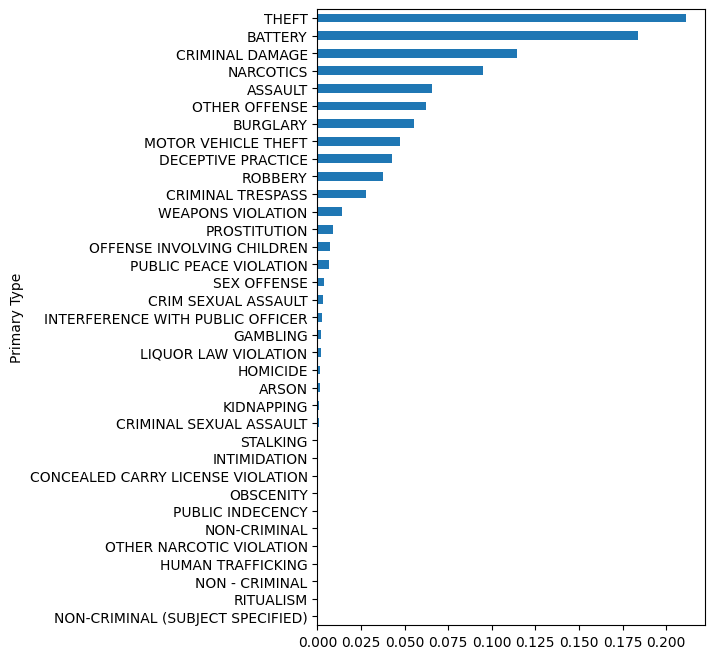

In [46]:
## Inspect the value_counts for the different types of crimes
crime_counts = df['Primary Type'].value_counts(normalize=True)
crime_counts.sort_values().plot(kind='barh',figsize=(5,8))


In [47]:
## Inspect the value_counts for the different types of crimes
crime_counts = df['Primary Type'].value_counts().to_frame('Total # of Crimes')
crime_counts


,Total # of Crimes
Primary Type,
THEFT,1484301
BATTERY,1287817
CRIMINAL DAMAGE,803658
NARCOTICS,667544
ASSAULT,459629
OTHER OFFENSE,435652
BURGLARY,388178
MOTOR VEHICLE THEFT,330699
DECEPTIVE PRACTICE,298475


In [48]:
# display with an inline-barplot inside your df
crime_counts.style.bar('Total # of Crimes')


,Total # of Crimes
Primary Type,
THEFT,1484301
BATTERY,1287817
CRIMINAL DAMAGE,803658
NARCOTICS,667544
ASSAULT,459629
OTHER OFFENSE,435652
BURGLARY,388178
MOTOR VEHICLE THEFT,330699
DECEPTIVE PRACTICE,298475


In [49]:
## demoing groupby with .counts() vs .size()
df.groupby("Primary Type").count().head()



,ID,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Latitude,Longitude,Month,Hour
Primary Type,,,,,,,,,,,,
ARSON,11734,11734,11734,11734,11734,11734,11734,11734,11734,11734,11734,11734
ASSAULT,459629,459629,459629,459629,459629,459629,459629,459629,459629,459629,459629,459629
BATTERY,1287817,1287817,1287817,1287817,1287817,1287817,1287817,1287817,1287817,1287817,1287817,1287817
BURGLARY,388178,388178,388178,388178,388178,388178,388178,388178,388178,388178,388178,388178
CONCEALED CARRY LICENSE VIOLATION,1011,1011,1011,1011,1011,1011,1011,1011,1011,1011,1011,1011


In [50]:
df.groupby("Primary Type").size().head()



Primary Type
ARSON                                  11734
ASSAULT                               459629
BATTERY                              1287817
BURGLARY                              388178
CONCEALED CARRY LICENSE VIOLATION       1011
dtype: int64

In [51]:
# 1. get list of  unique crime descriptions
crime_list = df['Primary Type'].unique()
crime_list



array(['OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'THEFT',
       'SEX OFFENSE', 'HOMICIDE', 'MOTOR VEHICLE THEFT', 'OTHER OFFENSE',
       'DECEPTIVE PRACTICE', 'BATTERY', 'CRIMINAL DAMAGE', 'ROBBERY',
       'ASSAULT', 'NARCOTICS', 'BURGLARY', 'CRIMINAL TRESPASS',
       'WEAPONS VIOLATION', 'ARSON', 'STALKING', 'PUBLIC PEACE VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'PROSTITUTION',
       'LIQUOR LAW VIOLATION', 'KIDNAPPING', 'INTIMIDATION',
       'CRIMINAL SEXUAL ASSAULT', 'GAMBLING', 'OBSCENITY',
       'HUMAN TRAFFICKING', 'CONCEALED CARRY LICENSE VIOLATION',
       'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'PUBLIC INDECENCY',
       'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'],
      dtype=object)

In [52]:
# 2. Create an empty dictionary
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
   temp = df.loc[ df['Primary Type']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts)
    # and keep ONLY the .size()
   temp_res = temp.resample("D").size()
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
   CRIMES[crime] = temp_res.copy()
CRIMES.keys()



dict_keys(['OFFENSE INVOLVING CHILDREN', 'CRIM SEXUAL ASSAULT', 'THEFT', 'SEX OFFENSE', 'HOMICIDE', 'MOTOR VEHICLE THEFT', 'OTHER OFFENSE', 'DECEPTIVE PRACTICE', 'BATTERY', 'CRIMINAL DAMAGE', 'ROBBERY', 'ASSAULT', 'NARCOTICS', 'BURGLARY', 'CRIMINAL TRESPASS', 'WEAPONS VIOLATION', 'ARSON', 'STALKING', 'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER', 'PROSTITUTION', 'LIQUOR LAW VIOLATION', 'KIDNAPPING', 'INTIMIDATION', 'CRIMINAL SEXUAL ASSAULT', 'GAMBLING', 'OBSCENITY', 'HUMAN TRAFFICKING', 'CONCEALED CARRY LICENSE VIOLATION', 'OTHER NARCOTIC VIOLATION', 'NON-CRIMINAL', 'PUBLIC INDECENCY', 'NON - CRIMINAL', 'NON-CRIMINAL (SUBJECT SPECIFIED)', 'RITUALISM'])

In [53]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df



,OFFENSE INVOLVING CHILDREN,CRIM SEXUAL ASSAULT,THEFT,SEX OFFENSE,HOMICIDE,MOTOR VEHICLE THEFT,OTHER OFFENSE,DECEPTIVE PRACTICE,BATTERY,CRIMINAL DAMAGE,...,GAMBLING,OBSCENITY,HUMAN TRAFFICKING,CONCEALED CARRY LICENSE VIOLATION,OTHER NARCOTIC VIOLATION,NON-CRIMINAL,PUBLIC INDECENCY,NON - CRIMINAL,NON-CRIMINAL (SUBJECT SPECIFIED),RITUALISM
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,66,26.0,138,17,2,3,5,17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-02,0,0.0,7,0,0,1,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,0,0.0,1,1,0,1,0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,0,0.0,0,0,0,0,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,0,0.0,1,0,0,2,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,4,NaN,121,2,0,74,29,18,71.0,59.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,2,NaN,89,0,1,98,34,14,98.0,69.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,2,NaN,115,1,2,88,29,15,93.0,89.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
# 1. get list of  unique crime descriptions
crime_list = df['Primary Type'].unique()

# 2. Create an empty dictionary
CRIMES = {}

# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
    temp = df.loc[ df['Primary Type']==crime].copy()

    # II. Resample the temp DataFrame as Daily data (crime counts)
    # and keep ONLY the .size()
    temp_res = temp.resample("D").size()

    #III. Save the temporary DataFrame in the dictionary,
    #using the crime description as the key.
    CRIMES[crime] = temp_res.copy()

# 4. Create new columns in the original DataFrame using the dictionary
df["THEFT"] = CRIMES["THEFT"]
df["BATTERY"] = CRIMES["BATTERY"]

In [64]:
crimes = ['THEFT','BATTERY']
crimes_ts = df[crimes].copy()
crimes_ts.head()



,THEFT,BATTERY
Date,,
2001-01-01 01:00:00,NaN,NaN
2001-01-01 01:00:00,NaN,NaN
2001-01-01 01:00:00,NaN,NaN
2001-01-01 13:00:00,NaN,NaN
2001-01-01 13:00:00,NaN,NaN


In [65]:
crimes_ts.isna().sum()



THEFT      6890697
BATTERY    6890819
dtype: int64

In [66]:
## fill null values with 0
crimes_ts = crimes_ts.fillna(0)
crimes_ts



,THEFT,BATTERY
Date,,
2001-01-01 01:00:00,0.0,0.0
2001-01-01 01:00:00,0.0,0.0
2001-01-01 01:00:00,0.0,0.0
2001-01-01 13:00:00,0.0,0.0
2001-01-01 13:00:00,0.0,0.0
...,...,...
2022-12-31 12:45:00,0.0,0.0
2022-12-31 12:50:00,0.0,0.0
2022-12-31 12:50:00,0.0,0.0


In [82]:
# Resample to monthly
ts = crimes_ts.resample("M").mean()
ts.head()


,THEFT,BATTERY
Date,,
2001-01-31,31.422604,0.110565
2001-02-28,56.728916,3.957831
2001-03-31,0.000000,0.000000
2001-04-30,0.000000,0.000000
2001-05-31,0.000000,0.000000


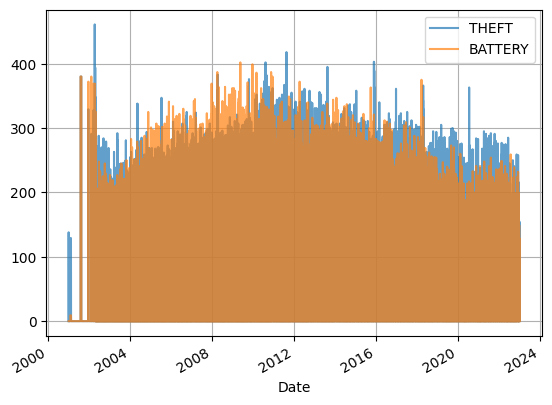

In [83]:
crimes_ts.plot(grid=True,alpha=0.7);



Identifying Seasonality

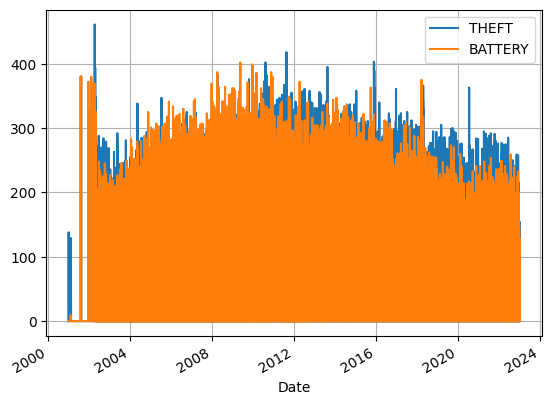

In [84]:
crimes_ts.index = pd.to_datetime(crimes_ts.index).sort_values()
plot_df = crimes_ts.loc['2000-01-01':'2024-12-31']
plot_df.plot(grid=True);

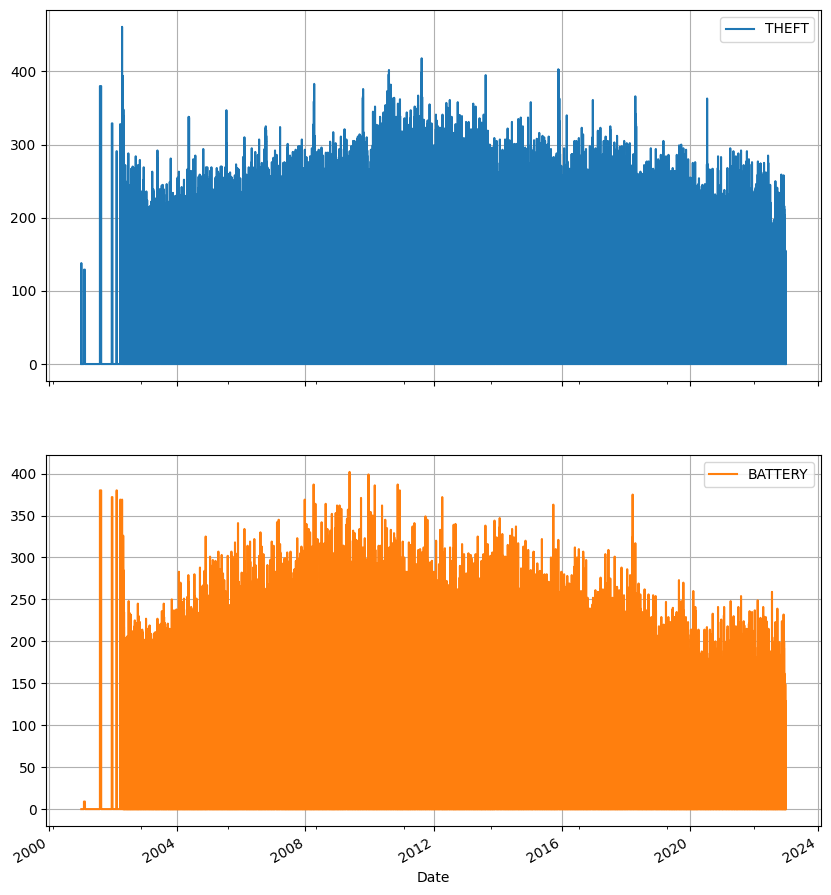

In [85]:
plot_df.plot(subplots=True,figsize=(10,12),grid=True);



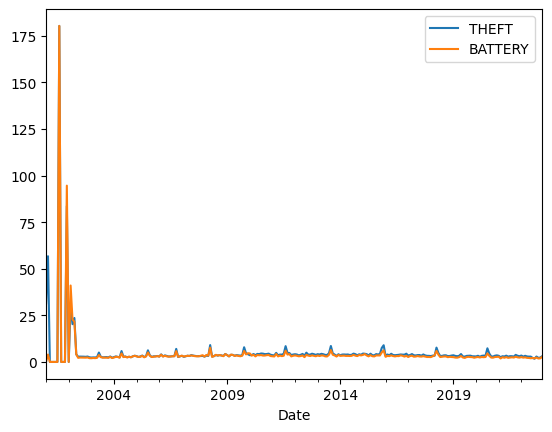

In [86]:
# Plot
ts.plot();

Our data is not seasonal

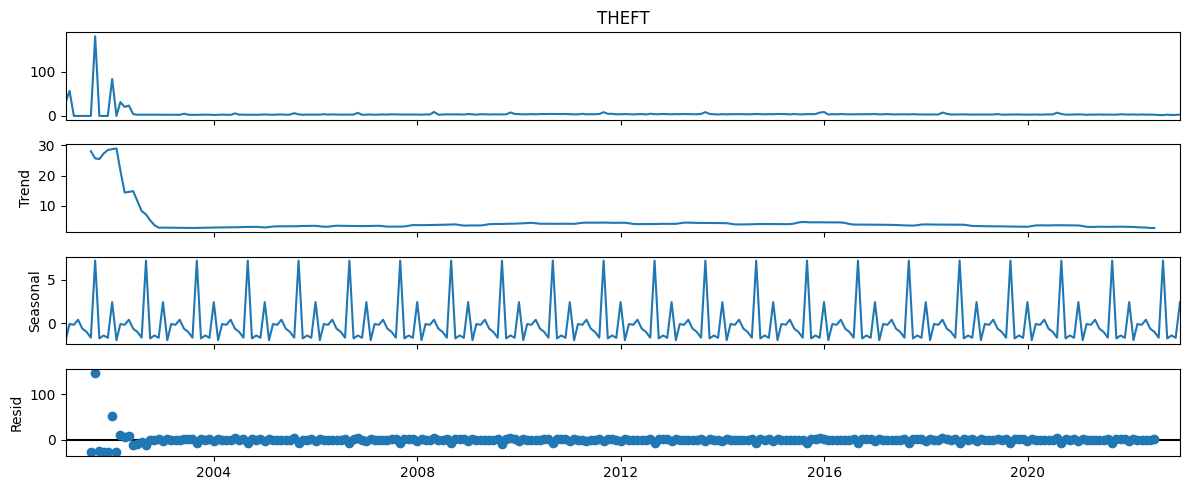

In [88]:
ts_series = ts.iloc[:, 0]
decomp = tsa.seasonal_decompose(ts_series)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [90]:
# Testing the raw data for stationarity
ts_series = ts.iloc[:, 0]  # Select the first column of the DataFrame
get_adfuller_results(ts_series)  # Pass the one-dimensional array to the function



,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-16.364124,0,263,0.0,0.05,True


<Axes: xlabel='Date'>

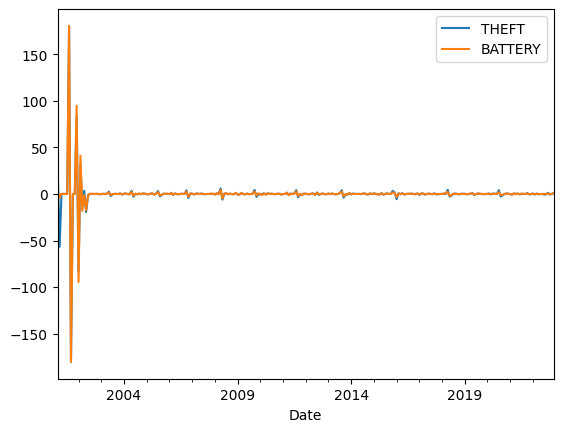

In [115]:
# Differencing the data once
ts_diff = ts.diff().dropna()
ts_diff.plot()

Our data is stationary so differencing is not required

In [98]:
# Select the first column of the DataFrame
ts_diff_series = ts_diff.iloc[:, 0]

# Pass the one-dimensional array to the function
get_adfuller_results(ts_diff_series)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-10.217829,15,247,0.0,0.05,True


In [117]:
ts_array = ts.values.flatten()
d = ndiffs(ts_array)

In [118]:
# use ndiffs to determine differencing
d = ndiffs(ts_array)
print(f'd is {d}')

d is 1


In [119]:
# Difference twice (d = 1)
ts_diff1 =ts.diff().diff().dropna()

In [121]:
ts_diff1 = ts_diff1.iloc[:, 0]

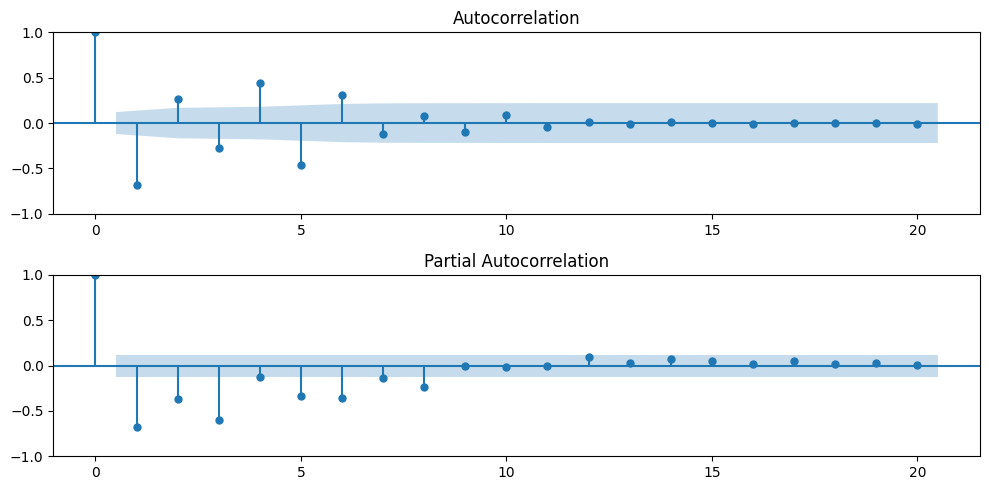

In [122]:
plot_acf_pacf(ts_diff1);

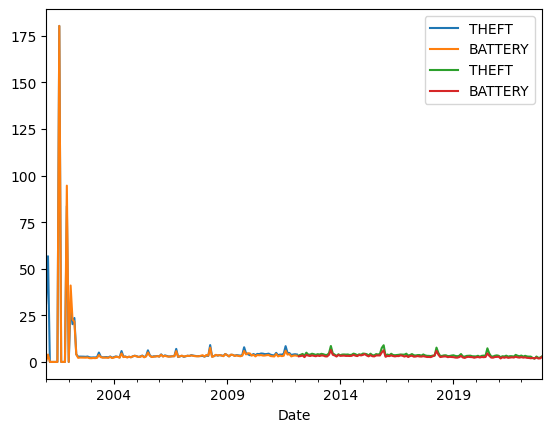

In [123]:
# Calculating number of test lags
n_test_lags = 5*26

# Modeling to predict 6 months into the future
train, test = train_test_split(ts, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();



Fit and Evaluate

We will now build and fit the ARIMA model using the selected parameters

In [129]:
# Build the model
p = 0  # AR component

d = 1  # Number of differencing required to make stationary

q =  1 # MA component

# Define and fit the model
train_univariate = train['THEFT']
arima_model = tsa.ARIMA(train_univariate, order=(p,d,q)).fit()

In [144]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true.to_numpy().ravel(), ts_pred.to_numpy().ravel())
    mse = mean_squared_error(ts_true.to_numpy().ravel(), ts_pred.to_numpy().ravel())
    rmse = mean_squared_error(ts_true.to_numpy().ravel(), ts_pred.to_numpy().ravel(), squared=False)

In [145]:
# Obtain summary of model
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  THEFT   No. Observations:                  134
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -570.172
Date:                Fri, 10 May 2024   AIC                           1144.344
Time:                        17:52:22   BIC                           1150.124
Sample:                    01-31-2001   HQIC                          1146.693
                         - 02-29-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9200      0.080    -11.497      0.000      -1.077      -0.763
sigma2       305.5314     21.794     14.019      0.000     262.816     348.246
===================================================================================
Ljung-Box (L1) (Q):                   2.47   Jarque-Bera (JB):             20671.69
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             6.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

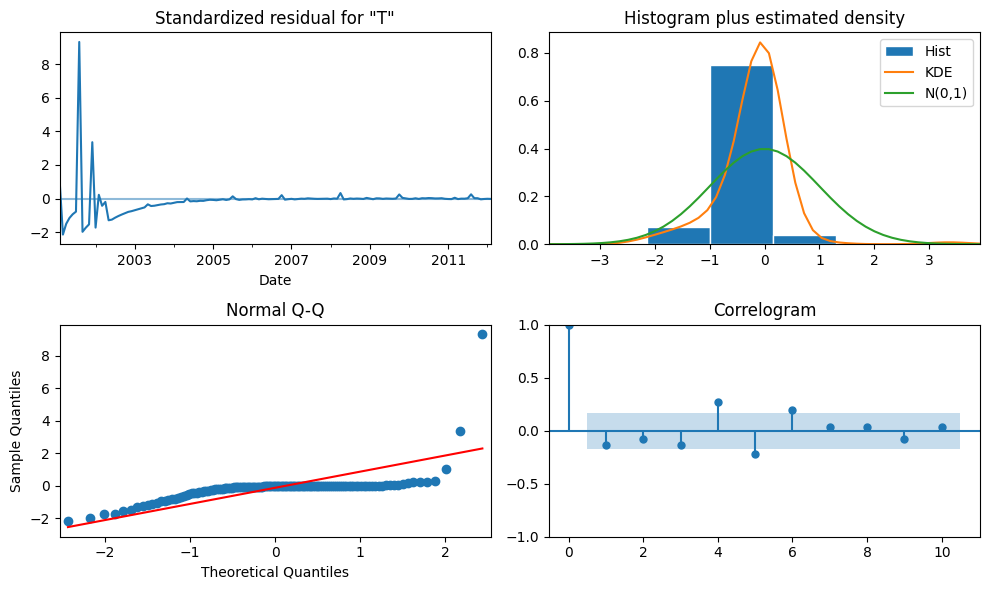

In [146]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [150]:
import itertools
# Rename the list variable to crime_data
crime_data = list

# Define the value or range of values for p, d, q
p_values = range(0, 4)
d_values = [0]
q_values = range(0, 4)

# Create combinations of pdq to test
pdq_to_try = itertools.product(p_values, d_values, q_values)
pdq_to_try